In [1]:
import juliet
import corner
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def rootdir(*args):
    return os.path.join("..", *args)

def datadir(*args):
    return rootdir("data", *args)

In [3]:
ground_truth = {
    "period": 3.5,
    "t0": 1.3,
    "us": [0.5, 0.2],
    "r": 0.03,
    "a": 10,
    "yerr": 1e-4
}

In [4]:
with np.load(datadir("generated_data_100ppm.npz")) as data:
    t = data["t"]
    flux = data["flux"]

In [5]:
priors = {
    "P_p1": dict(distribution="normal", hyperparameters=[ground_truth["period"], 0.1]),
    "t0_p1": dict(distribution="normal", hyperparameters=[1.3, 0.1]),
    "p_p1": dict(distribution="uniform", hyperparameters=[0.01, 0.1]), # r
    "b_p1": dict(distribution="fixed", hyperparameters=0),
    "a_p1": dict(distribution="normal", hyperparameters=[ground_truth["a"], ground_truth["a"]/10]),
    "ecc_p1": dict(distribution="fixed", hyperparameters=0),
    "omega_p1": dict(distribution="fixed", hyperparameters=90),
    "mdilution_fake": dict(distribution="fixed", hyperparameters=0),
    "mflux_fake": dict(distribution="fixed", hyperparameters=0),
    "q1_fake": dict(distribution="uniform", hyperparameters=[0, 1]),
    "q2_fake": dict(distribution="uniform", hyperparameters=[0, 1]),
    "sigma_w_fake": dict(distribution="truncatednormal", hyperparameters=[1e-4, 1, 0, np.inf]) # yerr
}

In [29]:
init = {
    "P_p1": ground_truth["period"],
    "t0_p1": ground_truth["t0"],
    "p_p1": ground_truth["r"],
    "b_p1": 0,
    "a_p1": ground_truth["a"],
    "ecc_p1": 0,
    "omega_p1": 90,
    "mdilution_fake": 0,
    "mflux_fake": 0,
    "q1_fake": ground_truth["us"][0],
    "q2_fake":ground_truth["us"][1],
    "sigma_w_fake": 1e-4
}

In [6]:
outpath = datadir("juliet/generated_data_100ppm")
os.makedirs(outpath, exist_ok=True)
dataset = juliet.load(priors=priors, t_lc=dict(fake=t), y_lc=dict(fake=flux), yerr_lc=dict(fake=np.zeros_like(flux)), out_folder=outpath)#, starting_point=init)

In [7]:
results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


1908it [00:37,  7.94it/s, bound: 1 | nc: 25 | ncall: 19470 | eff(%):  9.800 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.345 | dlogz:    inf >  0.509]

In [14]:
# Extract median model and the ones that cover the 68% credibility band around it:
transit_model, transit_up68, transit_low68  = results.lc.evaluate('fake', return_err=True)

# To plot the phased lighcurve we need the median period and time-of-transit center:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# Get phases:
phases = juliet.get_phases(dataset.times_lc['fake'], P, t0)

NameError: name 'results' is not defined

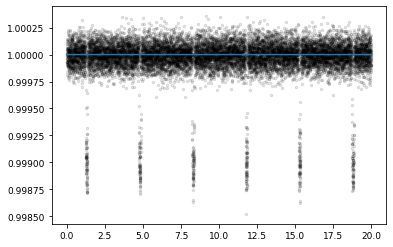

In [36]:
plt.scatter(t, flux, color="k", marker=".", alpha=0.1)
plt.plot(t, transit_model)

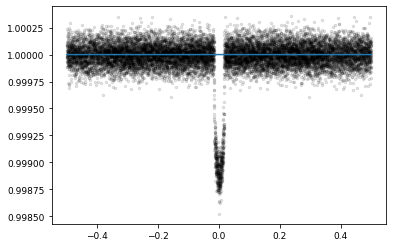

In [38]:
plt.scatter(phases, flux, color="k", marker=".", alpha=0.1)
idx = np.argsort(phases)
plt.plot(phases[idx], transit_model[idx])